In [1]:
# Aggregate the results and generate a plot
#
# Authors: Parisa Zahedi
#
# Dependencies: sklearn, numpy
# License: BSD-3-Clause

# pylint: disable=C0321

import os
import re
import glob
import warnings

from sklearn import metrics
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt


# df_summary = pd.read_csv(os.path.join('..','output', 'sr_lstm_results.csv'), index_col=0)
# df_summary


# fig, ax = plt.subplots()
# df_summary.set_index('training_size',inplace=True)
# df_summary.groupby(['training_size','init_included_papers']).mean()['to_read_number'].unstack().plot(ax=ax)
# ax.set_xlabel("Training size") 
# ax.set_ylabel("Number of papers to read (TP + FP)") 
# ax.set_title("Included papers based on the training size and the number of initially included papers")
# plt.show()

In [24]:
dataset_name ="ptsd"
#dataset_name ="ProtonPumpInhibitors"
#dataset_name = "BetaBlockers"
#dataset_name ="CalciumChannelBlockers"
#dataset_name = "Opiods"
#dataset_name = "ACEInhibitors"
#dataset_name = "AtypicalAntipsychotics"
#dataset_name = "Statins"

In [9]:
# store the result
column_names = ['T','tn','fp','fn','tp','allowed_FN','init_included_papers','dataset','seed','pred','training_size', 'dropout']
df_results = pd.DataFrame(columns=column_names)

# save the result to a file
for fp in glob.glob(os.path.join('..','output',dataset_name, 'dataset_{}_sr_lstm*.json'.format(dataset_name))):
    with open(fp) as json_file:
        # load the result into memory 
        json_data = json.load(json_file)
        json_data['pred'] = [json_data['pred']]
    df = pd.DataFrame(json_data)
    df_results = df_results.append(df)
df_results.to_csv(os.path.join('..', 'output',dataset_name, 'sr_lstm_results.csv'))

In [25]:
# dataset_name ="BetaBlockers"
df_results = pd.read_csv(os.path.join('..', 'output',dataset_name, 'sr_lstm_results.csv'), index_col='T')
    
df_results['recall'] = df_results['tp']/(df_results['tp']+df_results['fn'])
df_results['fp_rate'] = df_results['fp']/(df_results['fp']+df_results['fn'])

df_results['to_read_plus_train_number'] = (df_results['fp']+df_results['tp']+df_results['training_size'])
df_results['to_read_plus_train_rate'] = df_results['to_read_plus_train_number']/(df_results['fp']+df_results['fn']+df_results['tp']+df_results['tn']+df_results['training_size'])

df_results['to_read_number'] = (df_results['fp']+df_results['tp'])
df_results['to_read_rate'] = df_results['to_read_number']/(df_results['fp']+df_results['fn']+df_results['tp']+df_results['tn'])    

# include_training =False
# if include_training==True:
#     df_results['to_read_rate'] = (df_results['fp']+df_results['tp']+df_results['training_size'])/(df_results['fp']+df_results['fn']+df_results['tp']+df_results['tn']+df_results['training_size'])
#     df_results['to_read_number'] = (df_results['fp']+df_results['tp']+df_results['training_size'])
# else:
#     df_results['to_read_rate'] = (df_results['fp']+df_results['tp'])/(df_results['fp']+df_results['fn']+df_results['tp']+df_results['tn'])
#     df_results['to_read_number'] = (df_results['fp']+df_results['tp'])

    
# temp fix 
if dataset_name == 'ptsd':
    param_grid_df = pd.read_csv(os.path.join('..', 'output',dataset_name, 'ptsd_params.csv'), index_col='T')

    df_results = df_results.join(param_grid_df[['dropout']]).sort_index()


In [ ]:
# cond1=(df_results['training_size'].isin ([50,100,150,200])) & (df_results['dropout']==0.4)
# cond2=(df_results['training_size'].isin ([250,300,350,400,450,500])) & (df_results['dropout']==0)
# dff= df_results.loc[cond1|cond2]

In [8]:
sel_column_names = ['tn','fp','fn','tp','allowed_FN','init_included_papers','training_size','dropout']
df_results[sel_column_names]
df_results[sel_column_names].to_csv(os.path.join('..', 'output',dataset_name, 'results.csv'))

## Visualize training size and initial included papers

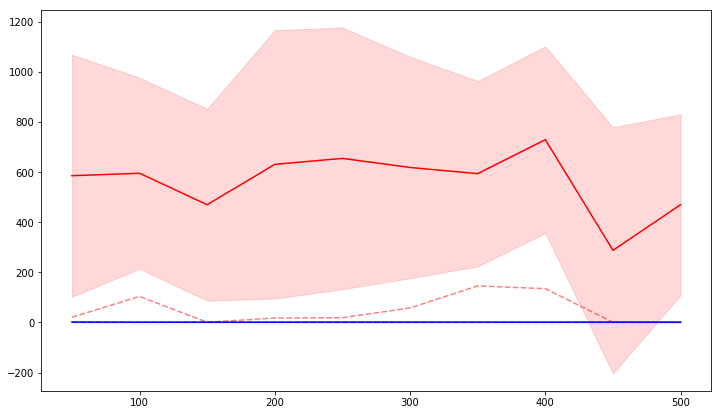

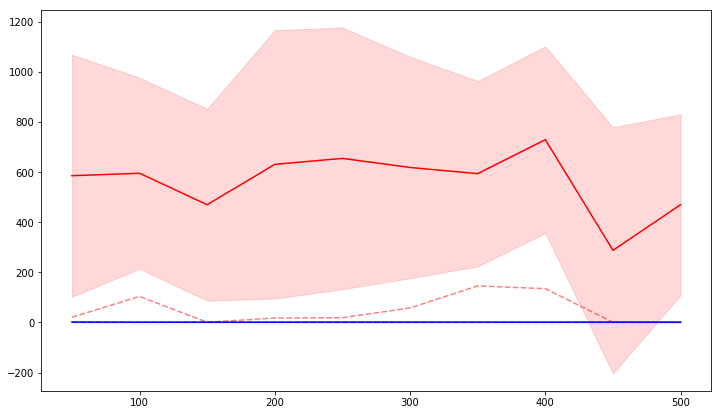

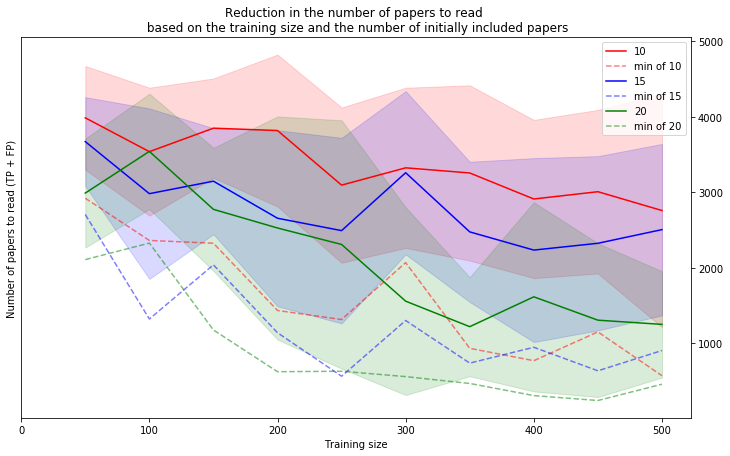

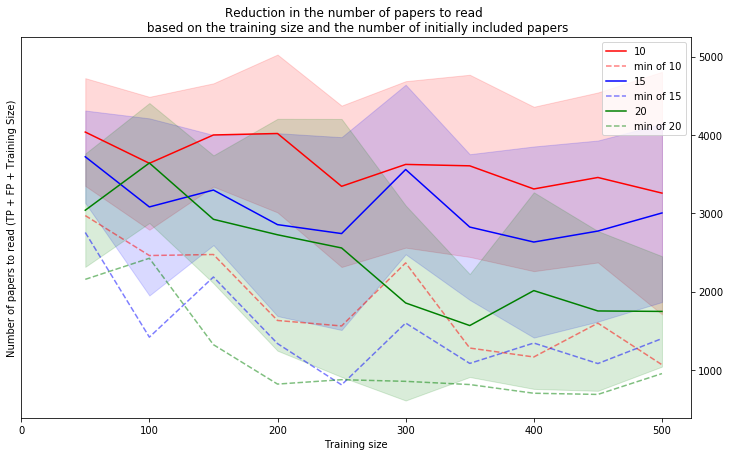

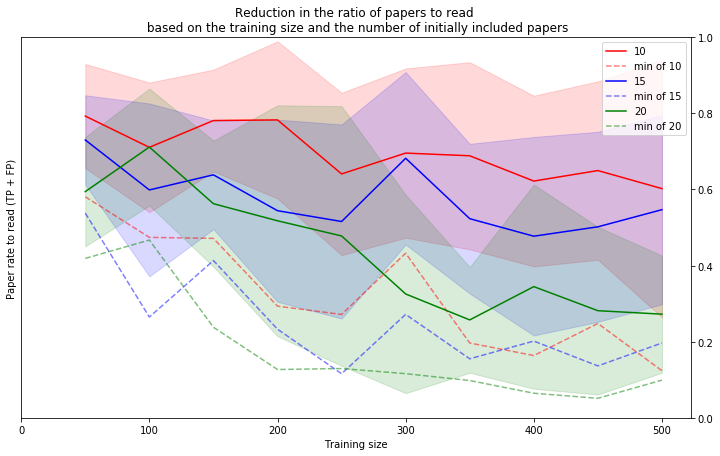

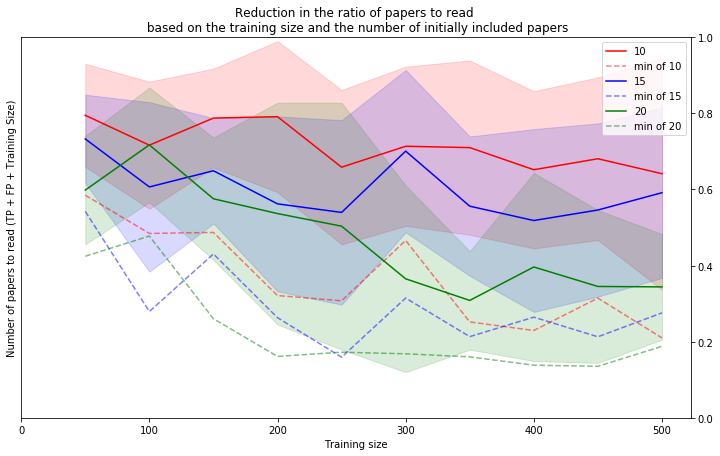

In [22]:
# selected_col_names = ['training_size','allowed_FN','init_included_papers','dataset','fp_rate','recall','to_read_number','to_read_rate','tn','fp','fn','tp']

cond = (df_results['allowed_FN'] == 1) & (df_results['dropout'] == 0.4)
df_summary = df_results.loc[cond,]

for r in ['to_read_number', 'to_read_plus_train_number', 'to_read_rate', 'to_read_plus_train_rate']:

    fig, ax = plt.subplots(figsize=(12, 7))
    m = df_summary.groupby(['training_size','init_included_papers']).mean()[r].unstack()
    st = df_summary.groupby(['training_size','init_included_papers']).std()[r].unstack()
    min_ = df_summary.groupby(['training_size','init_included_papers']).min()[r].unstack()


    col_dict = {10: 'r', 15: 'b', 20:'g'}
#     print(m)
#     print(st)
    for s in [10, 15, 20]:

        ax.plot(m.index, m[s], col_dict[s], label=s)
        ax.fill_between(m.index, m[s] - st[s], m[s] + st[s], color=col_dict[s], alpha=0.15)
        ax.plot(m.index, min_[s], "{}--".format(col_dict[s]), alpha=0.5, label="min of {}".format(s))


    ax.set_xlabel("Training size") 
    if r == 'to_read_number':
        ax.set_ylabel("Number of papers to read (TP + FP)") 
        ax.set_title("Reduction in the number of papers to read \n based on the training size and the number of initially included papers")
    elif r == 'to_read_plus_train_rate':
        ax.set_ylabel("Number of papers to read (TP + FP + Training Size)") 
        ax.set_ylim([0,1])
        ax.set_title("Reduction in the ratio of papers to read \n based on the training size and the number of initially included papers")
    elif r == 'to_read_plus_train_number':
        ax.set_ylabel("Number of papers to read (TP + FP + Training Size)") 
        ax.set_title("Reduction in the number of papers to read \n based on the training size and the number of initially included papers")
    elif r  == 'to_read_rate':
        ax.set_ylabel("Paper rate to read (TP + FP)") 
        ax.set_ylim([0,1])
        ax.set_title("Reduction in the ratio of papers to read \n based on the training size and the number of initially included papers")
    else:
        raise Exception
        
    ax.set_xlim(left=0)
    ax.yaxis.tick_right()

    ax.legend(loc='best')
    plt.show()
    
    if not os.path.isdir(os.path.join('..', 'output', 'figures', dataset_name)):
        os.mkdir(os.path.join('..', 'output', 'figures', dataset_name))
    fig.savefig(os.path.join('..','output', "figures", dataset_name, "perf_plot-{}_{}.png".format(r,dataset_name)))

## visualize dropout for lstm model

In [ ]:
# selected_col_names = ['training_size','allowed_FN','init_included_papers','dataset','fp_rate','recall','to_read_number','to_read_rate','tn','fp','fn','tp']

cond = (df_results['allowed_FN'] == 1) & (df_results['init_included_papers'] == 20)
df_summary = df_results.loc[cond,]

for r in ['to_read_number', 'to_read_rate']:

    fig, ax = plt.subplots(figsize=(12, 7))
    m = df_summary.groupby(['training_size','dropout']).mean()[r].unstack()
    st = df_summary.groupby(['training_size','dropout']).std()[r].unstack()
    min_ = df_summary.groupby(['training_size','dropout']).min()[r].unstack()


    col_dict = {0.0: 'r', 0.2: 'b', 0.4:'g'}
#     print(m)
#     print(st)
    for s in [0.0, 0.2, 0.4]:

        ax.plot(m.index, m[s], col_dict[s], label=s)
        ax.fill_between(m.index, m[s] - st[s], m[s] + st[s], color=col_dict[s], alpha=0.15)
        ax.plot(m.index, min_[s], "{}--".format(col_dict[s]), alpha=0.5, label="min of {}".format(s))


    ax.set_xlabel("Training size") 
    ax.set_ylabel("Number of papers to read (TP + FP)") 
    ax.set_title("Papers to read for different training sizes and dropout (LSTM)")
    ax.legend(loc='best')
    plt.show()
    
    if not os.path.isdir(os.path.join('..', 'output', 'figures', dataset_name)):
        os.mkdir(os.path.join('..', 'output', 'figures', dataset_name))
    fig.savefig(os.path.join('..','output', "figures", dataset_name, "perf_plot_dropout-{}_{}.png".format(r,dataset_name)))


In [ ]:
df_results[df_results['dataset']=='atypical']

In [ ]:
cond = (df_results['dataset']=='atypical') & (df_results['allowed_FN'].isin([0,1]))
df_summary_drug = df_results.loc[cond,selected_col_names]

for r in ['to_read_number', 'to_read_rate']:

    fig, ax = plt.subplots(figsize=(12, 7))
    m = df_summary_drug.groupby(['training_size','init_included_papers']).mean()[r].unstack()
    st = df_summary_drug.groupby(['training_size','init_included_papers']).std()[r].unstack()
    min_ = df_summary_drug.groupby(['training_size','init_included_papers']).min()[r].unstack()


    col_dict = {10: 'r', 15: 'b', 20:'g'}
    print(m)
    print(st)
    for s in [10, 15, 20]:

        ax.plot(m.index, m[s], col_dict[s], label=s)
        ax.fill_between(m.index, m[s] - st[s], m[s] + st[s], alpha=0.15)
        ax.plot(m.index, min_[s], "{}--".format(col_dict[s]), alpha=0.5, label="min of {}".format(s))


    ax.set_xlabel("Training size") 
    ax.set_ylabel("Number of papers to read (TP + FP)") 
    ax.set_title("Included papers based on the training size and the number of initially included papers")
    ax.legend(loc='best')
    plt.show()
    fig.savefig(os.path.join('..','output', "figures", "perf_plot_drug{}.png".format(r)))

In [ ]:
df_results['dataset'].unique()

In [ ]:
cond = (df_results['dataset']=='ptsd') & (df_results['training_size'] == 200)
df_summary = df_results.loc[cond,:]
df = df_summary.groupby('allowed_FN').agg(['mean', 'std'])['to_read_rate']
df

## Allowed False Negatives

Allowed false negatives vary between 0 and 9 papers (absolute numbers).  

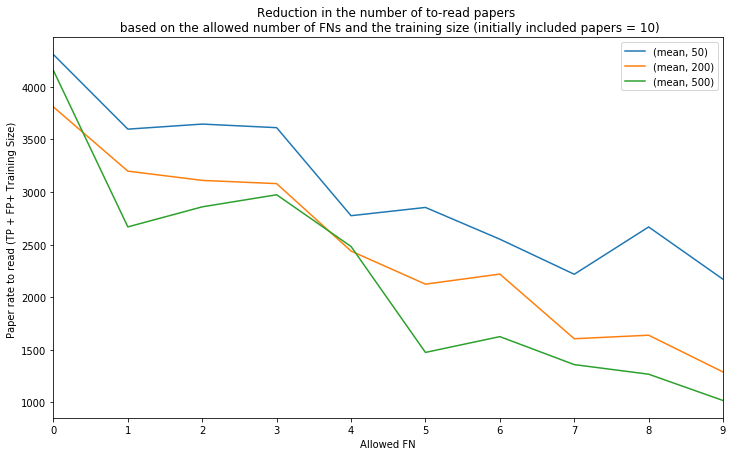

In [26]:
r = 'to_read_plus_train_number'

cond = (df_results['training_size'].isin([50, 200,500])) & (df_results['dropout'] == 0.4)
df_summary = df_results.loc[cond,:]

fig, ax = plt.subplots(figsize=(12, 7))

# df = df_summary.groupby('allowed_FN').agg(['mean', 'std'])['to_read_rate']
# ax.plot(df.index, df['mean'])
# # ax.fill_between(df.index, df.mean - df.std, df.mean + df.std, alpha=0.15)

df_summary.groupby(['allowed_FN','training_size']).agg(['mean'])[r].unstack().plot(ax=ax)

ax.set_xlabel("Allowed FN") 
ax.set_ylabel("Paper rate to read (TP + FP+ Training Size) ") 
ax.set_title("Reduction in the number of to-read papers \n based on the allowed number of FNs and the training size (initially included papers = 10)")
#ax.set_ylim([0,1])
ax.legend(loc='best')
plt.show()

if not os.path.isdir(os.path.join('..', 'output', 'figures', dataset_name)):
    os.mkdir(os.path.join('..', 'output', 'figures', dataset_name))
fig.savefig(os.path.join('..','output', "figures", dataset_name, "perf_plot_FN-{}_{}.png".format(r,dataset_name)))